# Tennis

---
### Start a new Environment

Before running this cell please make sure you have installed `unityagents` and the `Tennis Environment` is placed in your project folder. For further instructions please follow the the **Getting Started** section in this [README](https://github.com/danatt/drlnd-Tennis/blob/master/README.md) and change the *file_name* variable to match the location of the Unity environment that you downloaded.

In [1]:
from unityagents import UnityEnvironment
import numpy as np

# start a new environment
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


Episode 100	Average Score: -0.0025
Episode 200	Average Score: -0.0050
Episode 300	Average Score: -0.0035
Episode 400	Average Score: -0.0025
Episode 500	Average Score: -0.0050
Episode 600	Average Score: 0.00605
Episode 700	Average Score: 0.0145
Episode 800	Average Score: 0.0005
Episode 900	Average Score: 0.02255
Episode 1000	Average Score: 0.0690
Episode 1100	Average Score: 0.0829
Episode 1200	Average Score: 0.1040
Episode 1300	Average Score: 0.1565
Episode 1400	Average Score: 0.1585
Episode 1500	Average Score: 0.3432
Episode 1600	Average Score: 0.6385
Episode 1700	Average Score: 0.6969
Episode 1800	Average Score: 1.2751
Episode 1900	Average Score: 1.1360
Episode 2000	Average Score: 1.4915


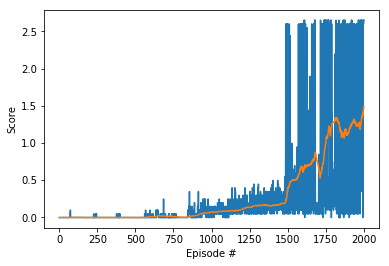

In [2]:
%reload_ext autoreload
%autoreload 2

import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from maddpg import MADDPG

#state_size, action_size, n_agnets, random_seed
agent = MADDPG(24, 2, 2, 0)

def maddpg(n_episodes=2000, print_every=100):
    """Learning by "Deep Deterministic Policy Gradient" - Method (DDPG)
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        print_every (int): print score every 'print_every' episodes
    """    
    
    scores_window = deque(maxlen=100)                      # save last 100 total scores in one episode
    all_scores = []
    avg_scores_window = []
    noise_damp = 0                                         # damping OU-Noise the closer it gets to global max
    max_score = 0                                          # save best score in that run
    
    for i_episode in range(1, n_episodes+1):

        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        states = env_info.vector_observations              # get the current state
        
        agent.reset()                                      # reset the agent                                     
        scores = np.zeros(num_agents)                      # initialize the score

        while True:
            actions = agent.act(states)                    # select an action from one agent
            env_info = env.step(actions)[brain_name]       # perform the action
            
            next_states = env_info.vector_observations          # get next state
            rewards = env_info.rewards                          # get reward
            dones = env_info.local_done                         # check done

            agent.step(states, actions, rewards, next_states, dones, num_updates=3) # agent step

            states = next_states
            scores += rewards

            if np.any(dones):
                break 
        
        # score for one episode of mean of all agents
        avg_score = np.mean(scores)
        
        # save last 100 avg_score scores
        scores_window.append(avg_score)
        
        all_scores.append(avg_score)
        avg_scores_window.append(np.mean(scores_window))
        noise_damp = np.mean(scores_window)
        
        print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_window)), end="")
        
        # save agent if 100 perfomance is better, that max_score
        if max_score < np.mean(scores_window):
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            max_score = np.mean(scores_window)
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_window)))
            
        if np.mean(scores_window) > 1.5:
            break
        
    return all_scores, avg_scores_window



all_scores, avg_scores_window = maddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(all_scores)+1), all_scores)
plt.plot(np.arange(1, len(avg_scores_window)+1), avg_scores_window)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [3]:
env.close()